# Colorization with Text

#### Make imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
#import keras
import os
from IPython.display import Image
import torch.nn as nn
import torch.nn.functional as F

os.chdir('/home/ek/disk/ERIK_DEEP_VISION_FINAL/')

import FINAL_PROJECT_dataset_class as fp

#### Load dataset

In [2]:
dataset = fp.Dataset(data_file_train='train_aux_flowers.npy',
                     data_file_test='augmented_test_birds.npy',
                     text_file_test='augmented_test_birds_text.npy',
                     text_file_train='train_texts_flowers_preprocessed.npy',
                     names_file = 'names_final.npy',
                     transpose=True,load_texts=True,aug_factor=2,load_embeddings = True)

loading 23560 samples
test images shape:  (200, 3, 64, 64)
train images shape:  (16178, 3, 64, 64)
samples successfully loaded
loading texts
loaded test text data:  (200, 10, 25)
loaded train text data:  (16178, 10, 25)


#### Define global variables

In [3]:
NUM_EMBEDDINGS = dataset.embeddings.shape[0]
N_DIM = dataset.embeddings.shape[1]

# Autoencoder conditioned on Text input

### Encoder

In [5]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.conv1 = nn.Conv2d(1,64,3,2)
        self.conv2 = nn.Conv2d(64,128,3,2)
        self.batchnorm = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128,256,3,2)
    def forward(self,input_,train=True):
        out = self.conv1(input_)
        out = F.relu(out)
        
        #print("conv1",out.shape)
        out = F.relu(self.conv2(out))
        if train:
            out = self.batchnorm(out)
        
        #print('conv2',out.shape)
        out = F.relu(self.conv3(out))
        #print("conv3",out.shape)
        return out

### Decoder

In [6]:
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.deconv1 = nn.ConvTranspose2d(256,128,3,2)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128,64,3,2)
        self.deconv3 = nn.ConvTranspose2d(64,3,4,2)
    def forward(self,input_,train=True):
        out = self.deconv1(input_)
        out = F.relu(out)
        if train:
            out= self.batchnorm2(out)
        #print("deconv1",out.shape)
        out = F.relu(self.deconv2(out))
        #print("deconv2",out.shape)
        out = self.deconv3(out)
        out = torch.sigmoid(out)
        #print("deconv3",out.shape)
        return out

### Embedding layer and LSTM many-to-one network

In [7]:
class Embedding(torch.nn.Module):
    def __init__(self,embedding):
        super(Embedding,self).__init__()
        self.embedding = torch.nn.Embedding(NUM_EMBEDDINGS,N_DIM,_weight=embedding)
        self.embedding.requires_grad = False
        self.lstm = torch.nn.LSTM(N_DIM,128,bidirectional = False,batch_first = True)
    def forward(self,input_text):
        out = self.embedding(input_text)
        
        #print('embedded shape : ',out.shape)
        out = self.lstm(out)
        #print('lstm shape:',out[0].shape)
        #print(out[0][-1])
        return out[1][0].view(out[1][0].shape[1],1,128)

### Fusion layer

This layer fuses the text input (already processed by the LSTM network) with the output of the encoder. This is done using tensor multiplication. Thus the input to the decoder is condition on the text input.

In [8]:
class Fusion_layer(torch.nn.Module):
    def __init__(self):
        super(Fusion_layer,self).__init__()
        self.weight = torch.nn.Parameter(torch.autograd.Variable(torch.randn(256,384)))
        self.bias = torch.nn.Parameter(torch.autograd.Variable(torch.zeros(256,)))
        self.batchnorm = nn.BatchNorm2d(256)
    def forward(self, encoder_out, embedding_out):
        batch_size = encoder_out.shape[0]
        print(self.weight.detach().cpu())
        self.weight.to('cuda')
        self.bias.to('cuda')
        embedding_out=torch.transpose(embedding_out.repeat((1,49,1)),-1,1).view(batch_size,128,7,7,1)
        out = torch.cat((encoder_out.view(batch_size,256,7,7,1),embedding_out),dim=1)
        #print('concatenated :',out.shape)
        out = out.permute(0,2,3,1,4) # batch,8,8,384,1 
        out = torch.nn.functional.relu(torch.matmul(self.weight.cuda(),out).view(batch_size,7,7,256)+self.bias.cuda())
        #print('output shape',out.shape)
        out = out.permute(0,3,1,2).cuda()
        out = self.batchnorm(out)
        return out

### Colorizer model

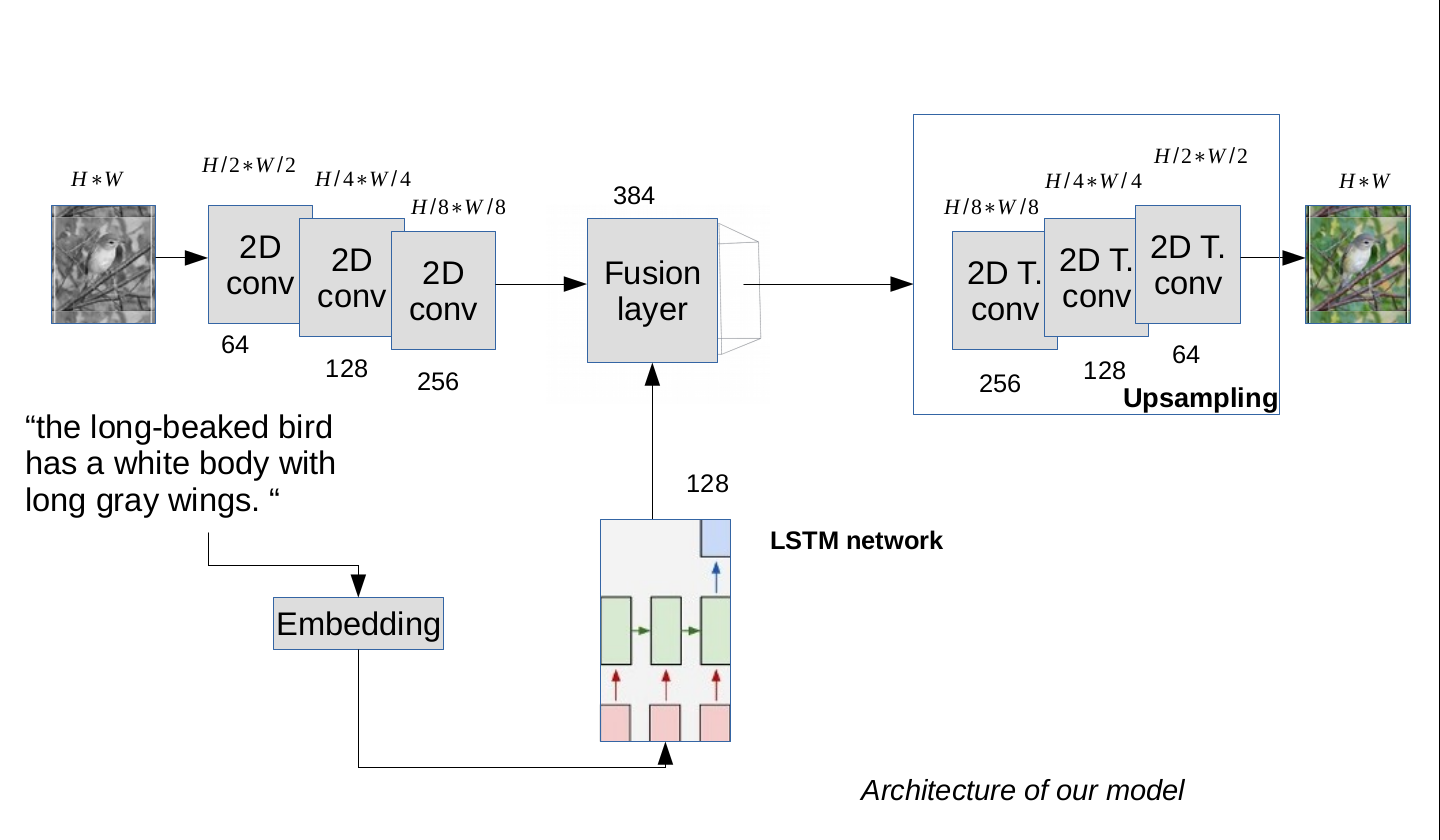

In [12]:
Image('architecture.png',width=700,height=700)

In [9]:
class Colorizer(torch.nn.Module):
    def __init__(self,embeddings):
        super(Colorizer,self).__init__()
        self.encoder = Encoder()
        self.embedding = Embedding(embeddings)
        self.fusion = Fusion_layer()
        self.decoder = Decoder()
    def forward(self,input_image,input_text):
        out = self.encoder(input_image)
        #print("shape at encoder out",out.shape)
        embedding = self.embedding(input_text)
        #print('embedding layer: ',embedding.shape)
        out = self.fusion(out,embedding)
        #print('fusion layer: ',out.shape)
        out = self.decoder(out)
        #print('final output: ',out.shape)
        return out

#### Define global variables

In [10]:
EPOCHS = 200
N_BATCHES_TRAIN = (dataset.n_samples-dataset.test_set_size)//dataset.batch_size
N_BATCHES_TEST = dataset.test_set_size//dataset.batch_size

#### Define train function

In [10]:
 def train(model,save = False):
    for epoch in range(EPOCHS):
        running_loss = 0.0
        data_in_epoch = dataset.load_data()

        for batch in data_in_epoch:
            #print('we here')
            #print(batch[0].shape)
            optimizer.zero_grad()
            #X = torch.Tensor(batch).to('cuda')
            #outputs = model(X)
            #cost = loss(outputs,X)
            outputs = model(torch.Tensor(np.mean(batch[0],axis = 1)[:,None,:,:]).to('cuda'),torch.LongTensor(batch[1][:,3]).cuda())
            cost = loss(outputs, torch.Tensor(batch[0]).to('cuda'))
            cost.backward()
            optimizer.step()
            running_loss += cost.item()
        print('training loss in epoch {} is : '.format(epoch),running_loss/N_BATCHES_TRAIN)
    
        data_in_epoch = dataset.load_data(False)
        for batch in data_in_epoch:
            #print(batch.shape)
            #X = torch.Tensor(batch).to('cuda')
            #outputs = model(X)
            #cost = loss(outputs,X)
            outputs = model(torch.Tensor(np.mean(batch[0],axis = 1)[:,None,:,:]).to('cuda'),torch.LongTensor(batch[1][:,3]).cuda())
            cost = loss(outputs, torch.Tensor(batch[0]).to('cuda'))
            running_loss += cost.item()
        print('test loss in epoch {} is : '.format(epoch),running_loss/N_BATCHES_TEST)
        if (epoch%100 == 0) and epoch!=0 and save:
            name = 'model'+str(epoch)
            torch.save(model.state_dict(),name)

# Testing the Colorizer Model

#### Testing the models without changes to the text 

model_full2 means more data was used in the training phase

In [13]:
model = Colorizer(torch.Tensor(dataset.embeddings))
model.cuda()
model.load_state_dict(torch.load('model_full2_200'))

In [ ]:
out = model(torch.Tensor(np.mean(dataset.train_images[:30],axis = 1)[:,None,:,:]).to('cuda')
            ,torch.LongTensor(dataset.train_texts[:30,3]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)
out = model(torch.Tensor(np.mean(dataset.test_images[:30],axis = 1)[:,None,:,:]).to('cuda')
            ,torch.LongTensor(dataset.test_texts[:30,3]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)

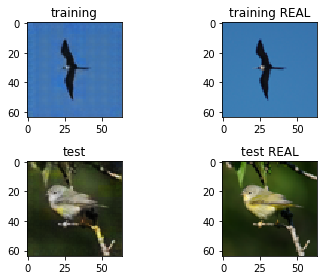

In [24]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[4].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[4],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[9].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[9],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

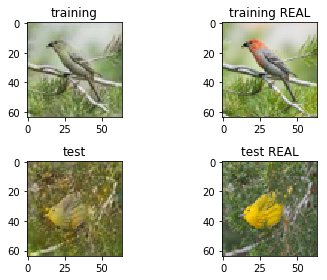

In [25]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[3].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[3],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[5].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[5],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

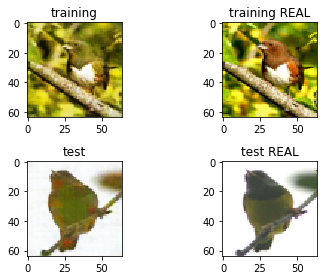

In [26]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[7].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[7],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[7].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[7],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

In [ ]:
model = Colorizer(torch.Tensor(dataset.embeddings))
model.cuda()
model.load_state_dict(torch.load('model_full2_500'))
model.eval()
out = model(torch.Tensor(np.mean(dataset.train_images[:30],axis = 1)[:,None,:,:]).to('cuda')
            ,torch.LongTensor(dataset.train_texts[:30,3]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)
out = model(torch.Tensor(np.mean(dataset.test_images[:30],axis = 1)[:,None,:,:]).to('cuda')
            ,torch.LongTensor(dataset.test_texts[:30,3]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)

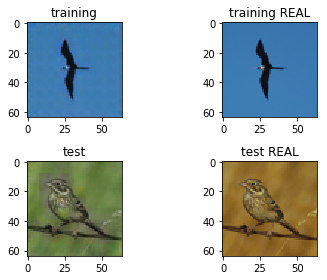

In [33]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[4].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[4],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[25].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[25],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

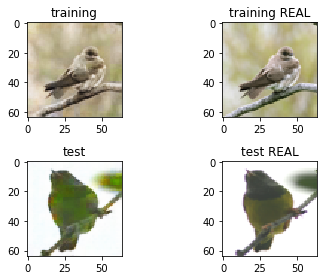

In [21]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[3].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[3],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[7].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[7],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

In [ ]:
model = Colorizer(torch.Tensor(dataset.embeddings))
model.cuda()
model.load_state_dict(torch.load('model_full2_500'))
out = model(torch.Tensor(np.mean(dataset.train_images[:30],axis = 1)[:,None,:,:]).to('cuda')
            ,torch.LongTensor(dataset.train_texts[:30,3]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)
out = model(torch.Tensor(np.mean(dataset.test_images[:30],axis = 1)[:,None,:,:]).to('cuda')
            ,torch.LongTensor(dataset.test_texts[:30,3]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)

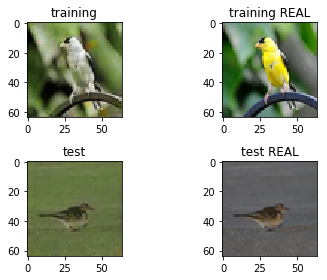

In [30]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[3].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[3],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[9].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[9],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

### Testing the model with changes to the text 

The bird whose color is changed is always shown at the bottom.

In [ ]:
dataset.test_texts[7,3,[-6]]=2 # black
dataset.test_texts[29,3,[-2]]=19 #red

In [ ]:
model = Colorizer(torch.Tensor(dataset.embeddings))
model.cuda()
model.load_state_dict(torch.load('model_full2_500'))
out = model(torch.Tensor(np.mean(dataset.train_images[:30],axis = 1)[:,None,:,:]).to('cuda')
            ,torch.LongTensor(dataset.train_texts[:30,3]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)
out = model(torch.Tensor(np.mean(dataset.test_images[:30],axis = 1)[:,None,:,:]).to('cuda')
            ,torch.LongTensor(dataset.test_texts[:30,3]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)

change green bird's (7th bird) color to black

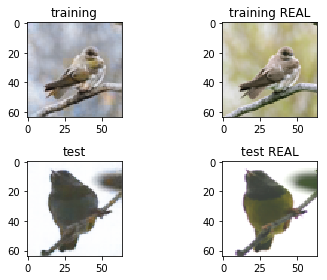

In [18]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[3].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[3],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[7].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[7],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

change undefined bird's (29th bird) color to red

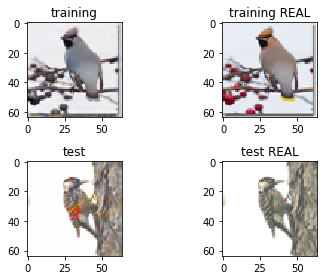

In [18]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[4].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[4],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[29].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[29],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

# Test on flowers dataset

Much more satisfying results are to be observed here, because the dataset was easier and the data was augmented

### Test withOUT changing the text

In [ ]:
model = Colorizer(torch.Tensor(dataset.embeddings))
model.cuda()
model.load_state_dict(torch.load('modelF_full200.npy'))
model.eval()
out = model(torch.Tensor(np.mean(dataset.train_images[:30],axis = 1)[:,None,:,:]).to('cuda')
            ,torch.LongTensor(dataset.train_texts[:30,3]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)
out = model(torch.Tensor(np.mean(dataset.test_images[:30],axis = 1)[:,None,:,:]).to('cuda')
            ,torch.LongTensor(dataset.test_texts[:30,3]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)

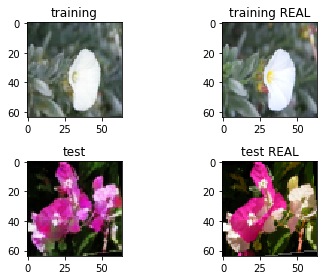

In [28]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(a[4].squeeze())
ax[0,0].set_title('training')
ax[0,1].imshow(np.transpose(dataset.train_images[4],(1,2,0)))
ax[0,1].set_title('training REAL')
ax[1,0].imshow(b[29].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[29],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

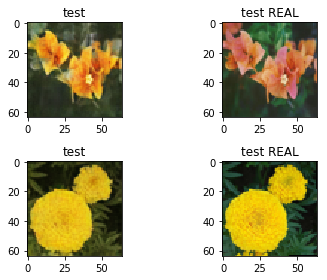

In [38]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(b[0].squeeze())
ax[0,0].set_title('test')
ax[0,1].imshow(np.transpose(dataset.test_images[0],(1,2,0)))
ax[0,1].set_title('test REAL')
ax[1,0].imshow(b[13].squeeze())
ax[1,0].set_title('test')
ax[1,1].imshow(np.transpose(dataset.test_images[13],(1,2,0)))
ax[1,1].set_title('test REAL')
plt.tight_layout()

### Test with changing the text

In [10]:
dataset.test_texts[13,3,-6]=4
dataset.test_texts[7,3,-6]=2
dataset.test_texts[29,3,-3]=2
dataset.test_texts[29,3,-4]=2

In [14]:
dataset.test_texts[13,3]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0, 100, 131,  66,   2,   1,  63,  94, 226,   4],
      dtype=int32)

In [ ]:
model = Colorizer(torch.Tensor(dataset.embeddings))
model.cuda()
model.load_state_dict(torch.load('modelF_full200.npy'))
model.eval()
out = model(torch.Tensor(np.mean(dataset.train_images[:30],axis = 1)[:,None,:,:]).to('cuda')
            ,torch.LongTensor(dataset.train_texts[:30,3]).cuda())
a = out.detach().cpu().numpy()
a = np.transpose(a,(0,2,3,1))
#a = 0.5*(a+1)
print(a.shape)
out = model(torch.Tensor(np.mean(dataset.test_images[:30],axis = 1)[:,None,:,:]).to('cuda')
            ,torch.LongTensor(dataset.test_texts[:30,3]).cuda())
b = out.detach().cpu().numpy()
b = np.transpose(b,(0,2,3,1))
#a = 0.5*(a+1)
print(b.shape)

change text of the 29th image to red (pic below)

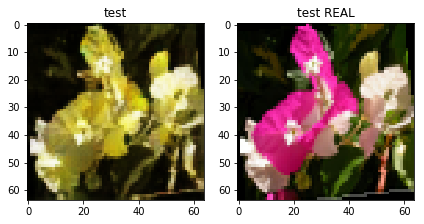

In [17]:
_,ax=plt.subplots(1,2)
ax[0].imshow(b[29].squeeze())
ax[0].set_title('test')
ax[1].imshow(np.transpose(dataset.test_images[29],(1,2,0)))
ax[1].set_title('test REAL')
plt.tight_layout()

change text of the 13th image to white (pic below)

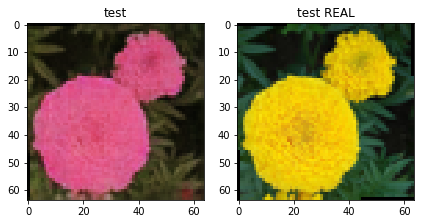

In [16]:
_,ax=plt.subplots(1,2)
ax[0].imshow(b[13].squeeze())
ax[0].set_title('test')
ax[1].imshow(np.transpose(dataset.test_images[13],(1,2,0)))
ax[1].set_title('test REAL')
plt.tight_layout()

change text of the 7th image to yellow (pic above)

Text(0.5, 1.0, 'test REAL')

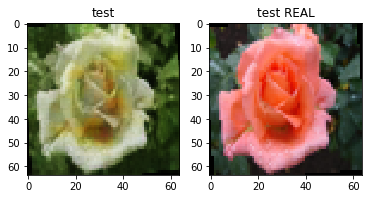

In [15]:
_,ax=plt.subplots(1,2)
ax[0].imshow(b[7].squeeze())
ax[0].set_title('test')
ax[1].imshow(np.transpose(dataset.test_images[7],(1,2,0)))
ax[1].set_title('test REAL')

In [33]:
word2idx

array({'petals': 1, 'yellow': 2, 'white': 3, 'pink': 4, 'purple': 5, 'stamen': 6, 'red': 7, 'green': 8, 'orange': 9, 'center': 10, 'long': 11, 'large': 12, 'shaped': 13, 'bright': 14, 'stigma': 15, 'pistil': 16, 'pedicel': 17, 'dark': 18, 'small': 19, 'light': 20, 'edges': 21, 'thin': 22, 'petal': 23, 'rounded': 24, 'pointed': 25, 'oval': 26, 'blue': 27, 'many': 28, 'flowers': 29, 'ruffled': 30, 'colored': 31, 'well': 32, 'leaves': 33, 'shape': 34, 'smooth': 35, 'layers': 36, 'anthers': 37, 'around': 38, 'stamens': 39, 'tips': 40, 'pale': 41, 'brown': 42, 'like': 43, 'wide': 44, 'together': 45, 'five': 46, 'anther': 47, 'black': 48, 'wavy': 49, 'filaments': 50, 'short': 51, 'round': 52, 'middle': 53, 'thick': 54, 'soft': 55, 'spots': 56, 'arranged': 57, 'sepals': 58, 'shown': 59, 'surrounded': 60, 'veins': 61, 'sepal': 62, 'surrounding': 63, 'lines': 64, 'several': 65, 'curled': 66, 'one': 67, 'overlapping': 68, 'darker': 69, 'pedals': 70, 'near': 71, 'bell': 72, 'spotted': 73, 'stem':

### Plot convergence

In [2]:
tl = np.load('/home/ek/disk/ERIK_DEEP_VISION_FINAL/train_loss.npy')

In [3]:
tel = np.load('/home/ek/disk/ERIK_DEEP_VISION_FINAL/test_loss.npy')
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Loss of model trained on Oxford flowers')

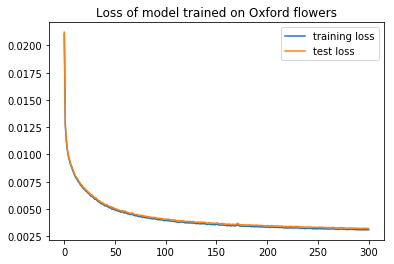

In [14]:
plt.plot(tl,label='training loss')
plt.plot(tel,label = 'test loss')
plt.legend()
plt.title('Loss of model trained on Oxford flowers')